Automaticaly tagging products resnet18.
Inspired by:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
# imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import torchvision.transforms.functional as TF

plt.ion()

In [2]:
# data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ]),
    'dev': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ])
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'dev', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'dev', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev', 'test']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

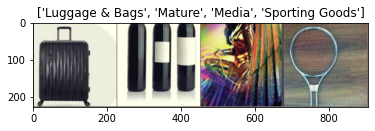

In [3]:
# look at some example from the dataset
def imshow(img, title=None):
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# get a batch
inputs, classes = next(iter(dataloaders['train']))

# make into grid
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [4]:
# define taining

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # train and validate each epoch
        for phase in ['train', 'dev']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero gradients at start
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy if is good
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))
    
    # return best weights
    model.load_state_dict(best_model_wts)
    return model
        
        

In [5]:
# visualize some predictions
def visualize_model(model, num_images=6, data='dev'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[data]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
# build model but block training on most layers, i.e. use convnet as a fixed feautre extractor
model_fc_only = models.resnet18(pretrained=True)

# turn off training
for param in model_fc_only.parameters():
    param.requires_grad = False
    

num_ftrs = model_fc_only.fc.in_features

# change fully connected layer to our number of classes
model_fc_only.fc = nn.Linear(num_ftrs, len(class_names)) # len(class_names) would also work

model_fc_only = model_fc_only.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_fc_only.parameters(), lr=0.001, momentum=0.9)

# decay lr
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
# this cell trains, will take not too long because it is fc only
model_fc_only = train_model(model_fc_only, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train loss: 2.6638 acc: 0.2368
dev loss: 1.8616 acc: 0.4643

Epoch 2/25
----------
train loss: 1.8667 acc: 0.4903
dev loss: 1.3622 acc: 0.5893

Epoch 3/25
----------
train loss: 1.5776 acc: 0.5471
dev loss: 1.1548 acc: 0.6607

Epoch 4/25
----------
train loss: 1.4910 acc: 0.5845
dev loss: 1.0743 acc: 0.6786

Epoch 5/25
----------
train loss: 1.4150 acc: 0.5789
dev loss: 0.9426 acc: 0.6964

Epoch 6/25
----------
train loss: 1.2495 acc: 0.6468
dev loss: 0.8291 acc: 0.6964

Epoch 7/25
----------
train loss: 1.1854 acc: 0.6551
dev loss: 0.7779 acc: 0.7143

Epoch 8/25
----------
train loss: 1.0822 acc: 0.6953
dev loss: 0.8021 acc: 0.7143

Epoch 9/25
----------
train loss: 1.0824 acc: 0.6981
dev loss: 0.8023 acc: 0.7500

Epoch 10/25
----------
train loss: 1.1043 acc: 0.6856
dev loss: 0.8213 acc: 0.7143

Epoch 11/25
----------
train loss: 1.0739 acc: 0.7050
dev loss: 0.7767 acc: 0.6964

Epoch 12/25
----------
train loss: 1.0558 acc: 0.7050
dev loss: 0.7509 acc: 0.7321

E

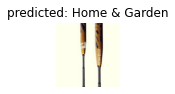

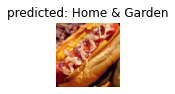

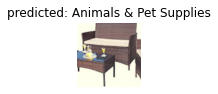

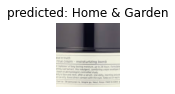

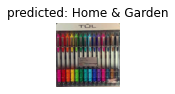

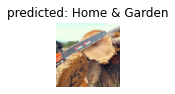

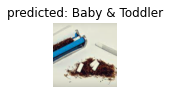

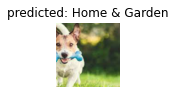

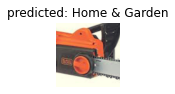

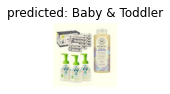

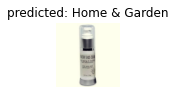

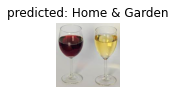

In [8]:
visualize_model(model_fc_only, data='dev')
visualize_model(model_fc_only, data='test')

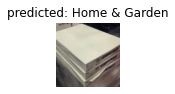

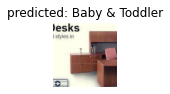

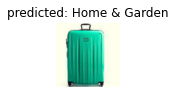

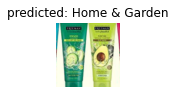

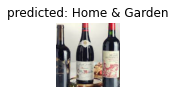

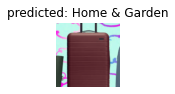

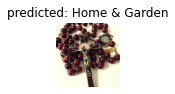

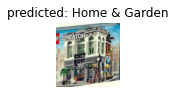

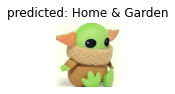

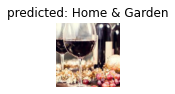

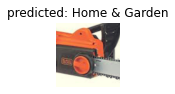

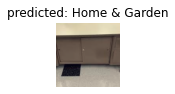

In [10]:
visualize_model(model_fc_only, data='dev')
visualize_model(model_fc_only, data='test')

In [11]:
def test_img(path):
    image = Image.open(path)
    x = TF.to_tensor(image)
    x.unsqueeze_(0)
#     print(x.shape)

    output = model_fc_only(x)
    print(output)
    print(torch.max(output, 1))

test_img('./data/hymenoptera_data/single_test/bee.jpeg')
test_img('./data/hymenoptera_data/single_test/ant.jpeg')

tensor([[ 0.0658,  0.2210, -0.2880,  0.1526,  0.2661,  0.0587, -0.0760, -0.1086,
          0.2981, -0.3790, -0.9929,  0.9381,  0.6890, -0.3914, -0.2494,  0.0598,
          0.1763, -0.0915, -0.4923,  0.2110,  0.2015]],
       grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([0.9381], grad_fn=<MaxBackward0>),
indices=tensor([11]))
tensor([[ 0.1029,  0.0189, -0.2054, -0.0742,  0.4740,  0.0020, -0.4796,  0.1705,
          0.2657, -0.7042, -0.8446,  1.4699,  0.7492, -0.4035, -0.3776,  0.1525,
          0.2906,  0.0714, -0.0999,  0.3846,  0.0901]],
       grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([1.4699], grad_fn=<MaxBackward0>),
indices=tensor([11]))


In [ ]:
test_img('./data/hymenoptera_data/single_test/bee.jpeg')
test_img('./data/hymenoptera_data/single_test/ant.jpeg')